# Behavenet Power Law Decoding

How populations of neurons in the visual cortex encode information is an open question. Some research has demonstrated that they maintain a balance between a high-dimensional, uncorrelated representation (highly flexible, but susceptible to noise) and a low-dimensional, correlated representation (less flexible, but robust to noise) [Stringer, et al., 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6642054/).

Additional research has found that natural images are encoded by a sparse amount of neurons. [Yoshida, Ohki, 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/32054847/) demonstrated that a single natural image is linearly decodable from a surprisingly small number of highly responsive neurons (~20), and the remaining neurons even degrade decoding. 

Do these properties hold for behavioral signals encoded in the visual cortex?

In [1]:
import scipy
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams.update({'font.size': 18, 'figure.figsize': (16, 8)})

import behavenet
from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.data.utils import get_transforms_paths
from behavenet.data.utils import load_labels_like_latents
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example

from behavenet.fitting.utils import get_best_model_and_data
from behavenet.fitting.eval import export_predictions
 

In [2]:
def plot_real_vs_predicted(
        latents, latents_predicted, title='', save_file=None, xtick_locs=None,  frame_rate=None, format='png'):
    """Plot real and sampled latents overlaying real and (potentially sampled) states.
    Parameters
    ----------
    latents : :obj:`np.ndarray`
        shape (n_frames, n_latents)
    latents_samp : :obj:`np.ndarray`
        shape (n_frames, n_latents)
    states : :obj:`np.ndarray`
        shape (n_frames,)
    states_samp : :obj:`np.ndarray`
        shape (n_frames,) if :obj:`latents_samp` are not conditioned on :obj:`states`, otherwise
        shape (0,)
    save_file : :obj:`str`
        full save file (path and filename)
    xtick_locs : :obj:`array-like`, optional
        tick locations in bin values for plot
    frame_rate : :obj:`float`, optional
        behavioral video framerate; to properly relabel xticks
    format : :obj:`str`, optional
        any accepted matplotlib save format, e.g. 'png' | 'pdf' | 'jpeg'
    Returns
    -------
    :obj:`matplotlib.figure.Figure`
        matplotlib figure handle
    """

    fig, ax = plt.subplots(1, 1, figsize=(16, 12))

        
    spc = 1.1 * abs(latents.max())
    n_latents = latents.shape[1]
    plotting_latents = latents + spc * np.arange(n_latents)
    plotting_predicted_latents = latents_predicted + spc * np.arange(n_latents)
    ymin = min(-spc - 1, np.min(plotting_latents))
    ymax = max(spc * n_latents, np.max(plotting_latents))
    ax.plot(plotting_latents, '-k', lw=3, label='AE Latents')
    ax.plot(plotting_predicted_latents, lw=3, alpha=0.8, label='Predicted AE latents')
    ax.set_ylim([ymin, ymax])

    ax.set_yticks([])

    ax.set_xlabel('Time (bins)')

    if xtick_locs is not None:
        ax.set_xticks(xtick_locs)
        if frame_rate is not None:
            ax.set_xticklabels((np.asarray(xtick_locs) / frame_rate).astype('int'))
            ax.set_xlabel('Time (sec)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title, fontsize=18)
    if save_file is not None:
        make_dir_if_not_exists(save_file)
        plt.savefig(save_file, dpi=300, format=format)

   # return fig

In [10]:
from behavenet.fitting.utils import get_subdirs
import os
          
def latent_results(expt_name=None, sess_id='', version='best', plot=False):
    # set model info
    sess_idx = 0
    hparams = {
        'data_dir': get_user_dir('data'),
        'save_dir': get_user_dir('save'),
        'model_class': 'neural-ae',
        'ae_model_type': 'conv',
        'ae_model_class': 'ae',
        'ae_experiment_name': 'latent_search',
        'n_ae_latents': 9,
        'experiment_name':'grid_search',
        'model_type':'mlp',
        'n_max_lags': 8,
        'rng_seed_data': 0,
        'trial_splits': '8;1;1;0'
    }

    hparams['neural_ae_experiment_name'] = hparams['experiment_name']
    hparams['neural_ae_model_type'] = hparams['model_type']
    hparams['neural_ae_version'] = version
    
    get_lab_example(hparams, 'dipoppa', sess_id)
    
    hparams['session_dir'], sess_ids = get_session_dir(hparams)
    expt_dir = get_expt_dir(hparams)
    
    ## Get discrete chance performance (accuracy of always predicting the most common training state)
    _, latents_file = get_transforms_paths('ae_latents', hparams, sess_ids[sess_idx])
    with open(latents_file, 'rb') as f:
        all_latents = pickle.load(f)
    mean_ae_latents = np.mean(np.concatenate([all_latents['latents'][i] for i in all_latents['trials']['train']]),axis=0)

    all_test_latents = np.concatenate([all_latents['latents'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    chance_ae_performance = np.mean((all_test_latents-mean_ae_latents)**2)
    
    ## Get discrete prediction performance
    # If sub-sampling - make sure to get results labelled by sample method and index name 
    if expt_name is not None:
        hparams['subsample_method'] = 'single'
        hparams['subsample_idxs_name'] = expt_name
        
    _, latent_predictions_file = get_transforms_paths('neural_ae_predictions', hparams, sess_ids[sess_idx])
    if not os.path.exists(latent_predictions_file):
        model, data_generator = get_best_model_and_data(hparams, Decoder, load_data=True, version=version)
        predictions = export_predictions(data_generator, model)
        
    with open(latent_predictions_file, 'rb') as f:
        all_latent_predictions = pickle.load(f)
    all_test_latent_predictions = np.concatenate([all_latent_predictions['predictions'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    decoding_ae_performance = np.mean((all_test_latents-all_test_latent_predictions)**2)
    r2 = r2_score(all_test_latents, all_test_latent_predictions)
    
    if plot:
        plot_real_vs_predicted(all_test_latents, all_test_latent_predictions, title='Latent Reconstruction: ' + expt_name)
    return chance_ae_performance, decoding_ae_performance, r2


In [12]:
samples = [20, 40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1370]
sess_ids = ['MD0ST5_4']
decoding_errors = {}

failures = []
for sess_id in sess_ids:
    print('[%s]'%sess_id)
    decoding_errors[sess_id] = {}
    for sample_size in samples:
        print('\tSample Size: ', sample_size)
        decoding_errors[sess_id][sample_size] = []
        for i in range(50):
            expt_name = 'n{}_t{}'.format(sample_size, i)
            #print('\tLoading results for ', expt_name)
            
            try:
                chance, decoding, r2 = latent_results(expt_name=expt_name, sess_id=sess_id)
                decoding_errors[sess_id][sample_size].append((chance, decoding, r2))
            except:
                print('\tFailure on session: ', sess_id, 'trial: ',expt_name)
                failures.append(expt_name)


[MD0ST5_4]
	Sample Size:  20
	Failure on session:  MD0ST5_4 trial:  n20_t8
	Failure on session:  MD0ST5_4 trial:  n20_t12
	Failure on session:  MD0ST5_4 trial:  n20_t29
	Failure on session:  MD0ST5_4 trial:  n20_t36
	Failure on session:  MD0ST5_4 trial:  n20_t43
	Failure on session:  MD0ST5_4 trial:  n20_t44
	Failure on session:  MD0ST5_4 trial:  n20_t45
	Sample Size:  40
	Failure on session:  MD0ST5_4 trial:  n40_t0
	Failure on session:  MD0ST5_4 trial:  n40_t4
	Failure on session:  MD0ST5_4 trial:  n40_t13
	Failure on session:  MD0ST5_4 trial:  n40_t27
	Failure on session:  MD0ST5_4 trial:  n40_t38
	Failure on session:  MD0ST5_4 trial:  n40_t42
	Failure on session:  MD0ST5_4 trial:  n40_t49
	Sample Size:  60
	Failure on session:  MD0ST5_4 trial:  n60_t14
	Failure on session:  MD0ST5_4 trial:  n60_t28
	Failure on session:  MD0ST5_4 trial:  n60_t42
	Failure on session:  MD0ST5_4 trial:  n60_t47
	Sample Size:  80
	Failure on session:  MD0ST5_4 trial:  n80_t0
	Failure on session:  MD0ST5

In [13]:
def get_results(res, session, samples, signal):
    '''
    Params:
        res: dict of results (from above cell)
        session: Session ID in dict
        samples: array of # neurons used in decoding
        signal: 'r2' | 'mse' | 'chance' --> what value to plot
    '''
    
    idx = 0
    if signal == 'r2':
        idx = 2
    elif signal == 'mse':
        idx = 1
    elif signal == 'chance':
        idx = 0
    else:
        raise ValueError('The only signals available are r2, mse, and chance')
        
    ret = []
    vals = res[session]
    
    # Iterate through dict of results and gather relevant metric
    for sample in samples:
        sample_vals = []
        for trial in vals[sample]:
            sample_vals.append(trial[idx])
        ret.append(sample_vals)
        
    return ret

def random_hex():
    random_number = np.random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    return hex_number

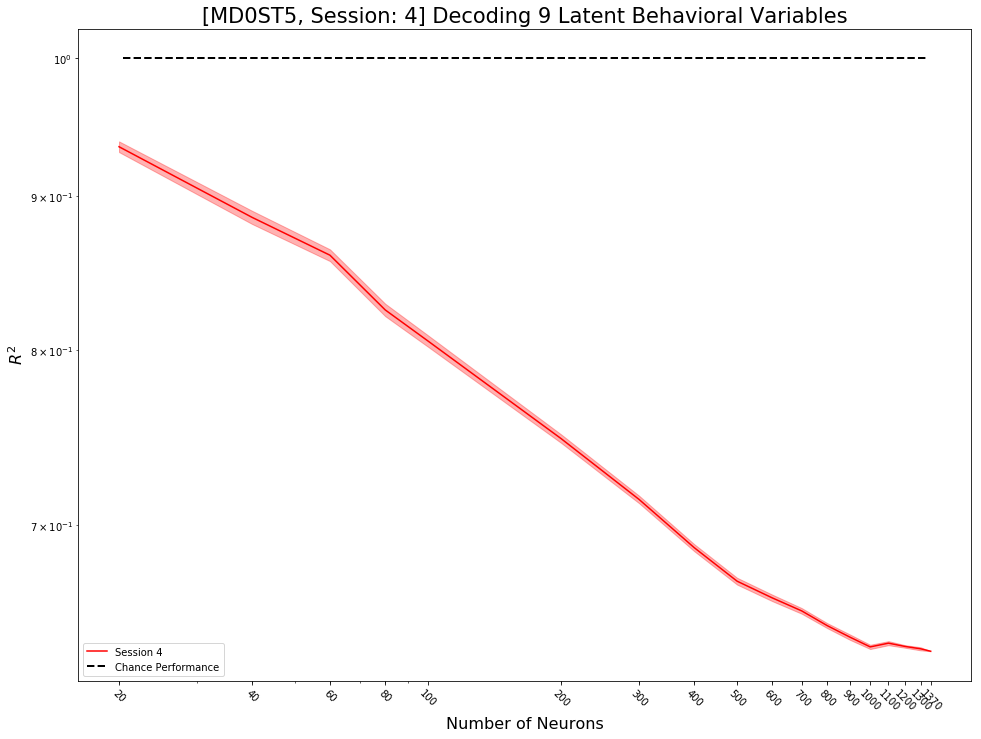

In [15]:
from scipy.stats import sem
fig, ax = plt.subplots(figsize=(16,12))
ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)

plt.grid = True

colors = ['red']
st = 0 # where to start on the x axis (ie; to start plot from 100 neurons, set st = 3)
for i, sess in enumerate(sess_ids):
    res = get_results(decoding_errors, sess, samples, 'mse')
    chances = get_results(decoding_errors, sess, samples, 'chance')
    chance = np.mean(chances[i])

    means = np.array([np.mean(t) for t in res[st:]]) / chance
    std_error = np.array([sem(t) for t in res[st:]]) / chance

    color = colors[i]
        
    sns.lineplot(samples[st:], means, label='Session %d'%(i+4), color=color)
    plt.fill_between(samples[st:], means+std_error, means-std_error, color=color, alpha=0.3)
    
plt.ylabel(r'$R^2$', fontsize=16)
plt.xlabel('Number of Neurons', fontsize=16)

plt.xticks(samples, samples, rotation=-45)
plt.axhline(1, 0.05, 0.95, color='black', linestyle='--', linewidth=2, label='Chance Performance')
plt.legend()
plt.title('[MD0ST5, Session: 4] Decoding 9 Latent Behavioral Variables', fontsize=21)

plt.show()
